In [2]:
# Load the Twitter sentiment data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the data
df = pd.read_csv('C:/Users/hp/Downloads/twitter_merged.csv', encoding='utf-8')

# Display basic information
print(df.head(10))
print('\
')
print(df.info())
print('\
')
print(df.describe())

     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   
5  2401  Borderlands  Positive   
6  2402  Borderlands  Positive   
7  2402  Borderlands  Positive   
8  2402  Borderlands  Positive   
9  2402  Borderlands  Positive   

                                                Text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
5  im getting into borderlands and i can murder y...  
6  So I spent a few hours making something for fu...  
7  So I spent a couple of hours doing something f...  
8  So I spent a few hours doing something for fun...  
9  So I spent a few hours making something for fu...  

<class 'pandas.core

In [3]:
# Check the shape and unique values
print('Dataset shape: ' + str(df.shape))
print('\
')
print('Unique entities: ' + str(df['Entity'].nunique()))
print('Entities: ' + str(df['Entity'].unique().tolist()))
print('\
')
print('Sentiment distribution:')
print(df['Sentiment'].value_counts())
print('\
')
print('Missing values:')
print(df.isnull().sum())

Dataset shape: (75682, 4)

Unique entities: 32
Entities: ['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch', 'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)', 'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends', 'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone', 'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon', 'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty', 'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)', 'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077', 'TomClancysGhostRecon', 'Nvidia']

Sentiment distribution:
Negative      22808
Positive      21109
Neutral       18603
Irrelevant    13162
Name: Sentiment, dtype: int64

Missing values:
ID             0
Entity         0
Sentiment      0
Text         686
dtype: int64


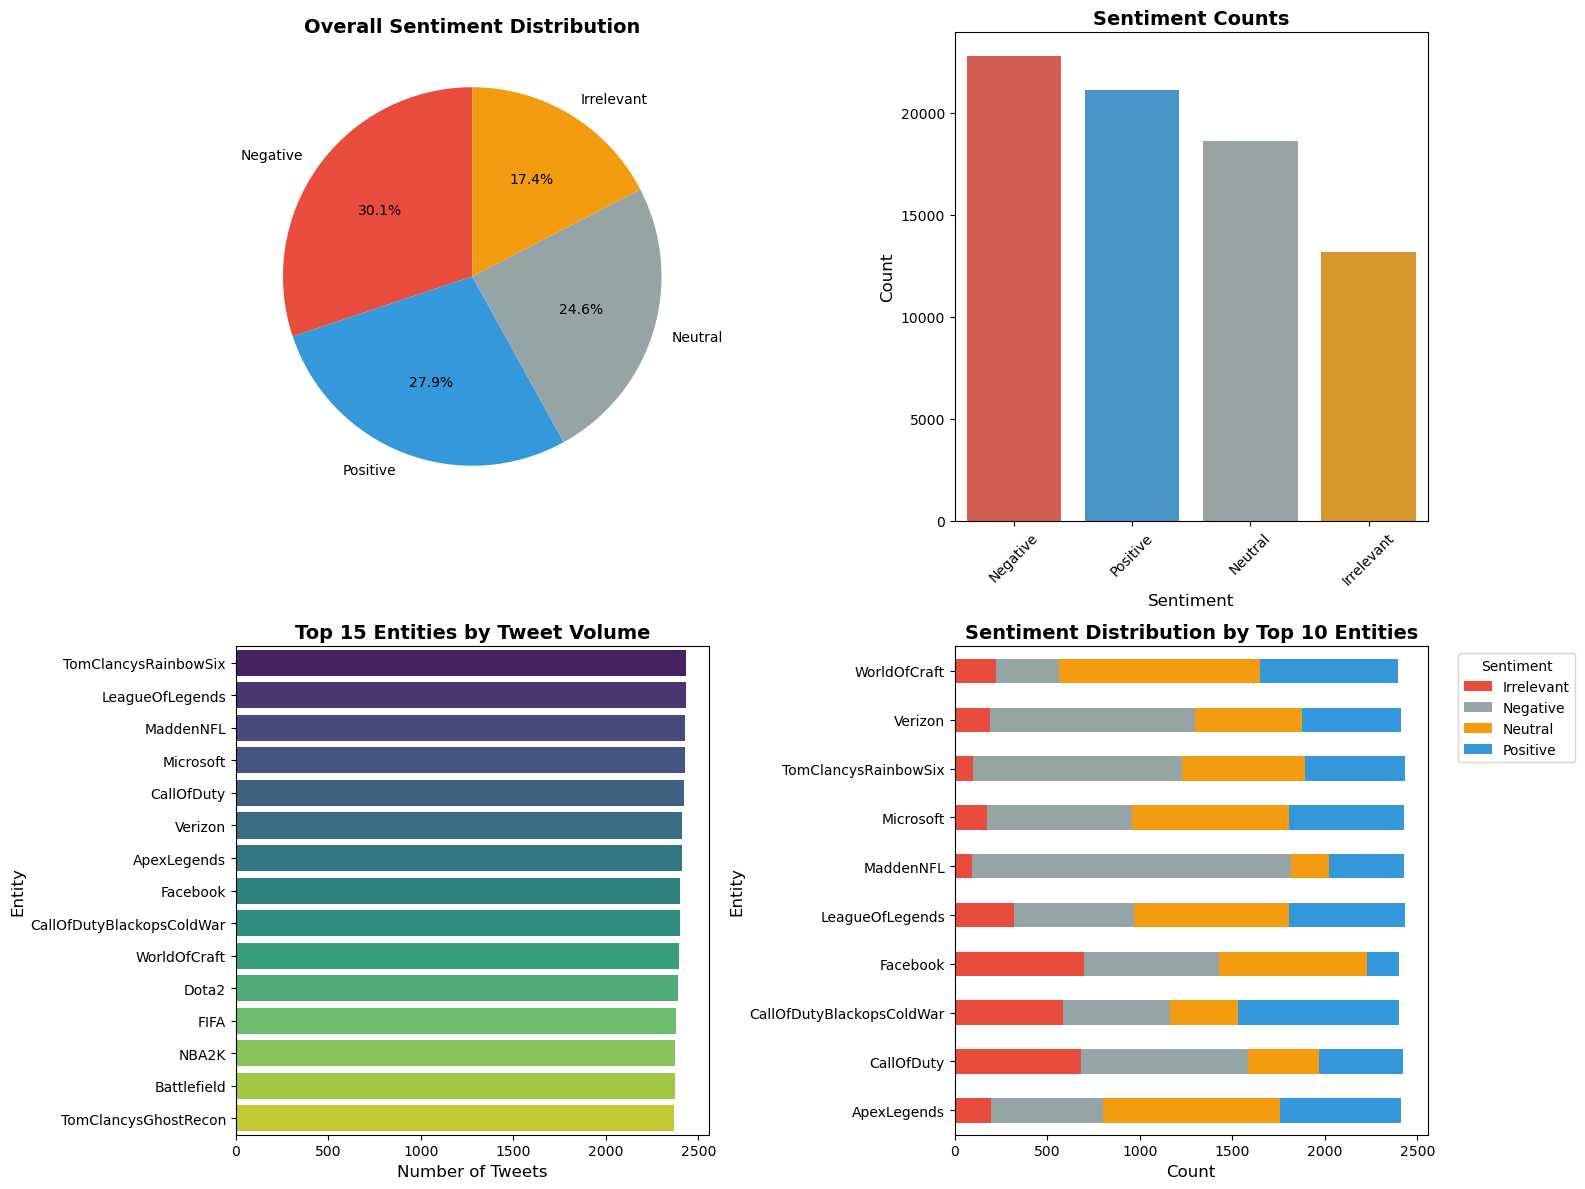

In [4]:
# Create comprehensive sentiment visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
colors = ['#e74c3c', '#3498db', '#95a5a6', '#f39c12']
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 0].set_title('Overall Sentiment Distribution', fontsize=14, fontweight='bold')

# 2. Sentiment counts bar chart
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors, ax=axes[0, 1])
axes[0, 1].set_title('Sentiment Counts', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Top 15 entities by tweet count
entity_counts = df['Entity'].value_counts().head(15)
sns.barplot(y=entity_counts.index, x=entity_counts.values, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Top 15 Entities by Tweet Volume', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Tweets', fontsize=12)
axes[1, 0].set_ylabel('Entity', fontsize=12)

# 4. Sentiment by top entities
top_entities = df['Entity'].value_counts().head(10).index
top_entities_df = df[df['Entity'].isin(top_entities)]
sentiment_by_entity = pd.crosstab(top_entities_df['Entity'], top_entities_df['Sentiment'])
sentiment_by_entity.plot(kind='barh', stacked=True, ax=axes[1, 1], 
                         color=['#e74c3c', '#95a5a6', '#f39c12', '#3498db'])
axes[1, 1].set_title('Sentiment Distribution by Top 10 Entities', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Count', fontsize=12)
axes[1, 1].set_ylabel('Entity', fontsize=12)
axes[1, 1].legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

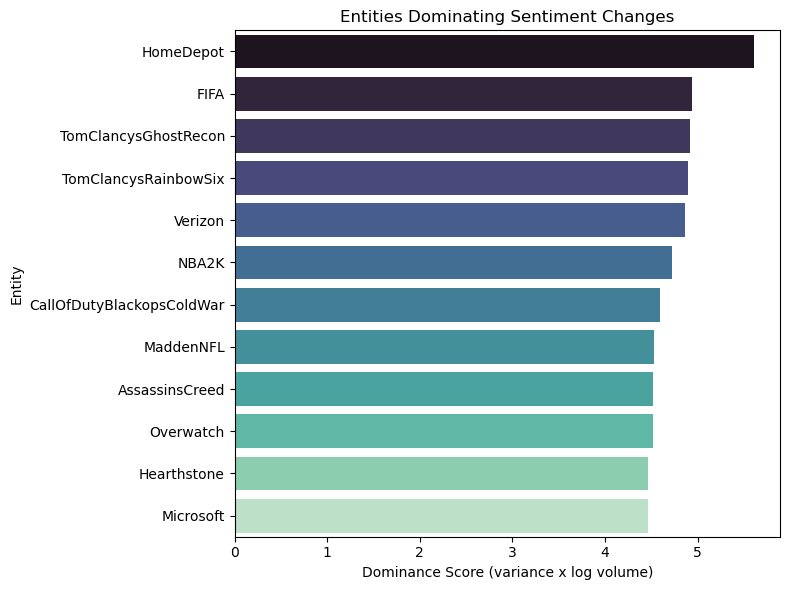

['HomeDepot', 'FIFA', 'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon', 'NBA2K', 'CallOfDutyBlackopsColdWar', 'MaddenNFL', 'AssassinsCreed', 'Overwatch', 'Hearthstone', 'Microsoft']
Plotted top entities by dominance score


In [5]:
# Plot top entities by dominance score (variance * log volume) to show who drives sentiment swings
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure ct exists; compute if not
try:
    ct
except NameError:
    sent_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    df['sent_score'] = df['Sentiment'].map(sent_map).fillna(0)
    ct = df.pivot_table(index='Entity', columns='Sentiment', values='ID', aggfunc='count', fill_value=0)
    ct['volume'] = ct.sum(axis=1)
    for s in ['Positive','Negative','Neutral','Irrelevant']:
        if s not in ct.columns:
            ct[s] = 0
    import numpy as np
    ct['pos_share'] = ct['Positive'] / ct['volume'].replace(0, np.nan)
    ct['neg_share'] = ct['Negative'] / ct['volume'].replace(0, np.nan)
    ct['net_sent'] = ct['pos_share'] - ct['neg_share']
    sent_var = df.groupby('Entity')['sent_score'].var(ddof=0)
    ct['sent_var'] = sent_var
    from scipy.stats import entropy
    probs = ct[['Positive','Negative','Neutral','Irrelevant']].div(ct['volume'], axis=0).replace(0, np.nan)
    ct['sent_entropy'] = probs.apply(lambda r: entropy(r.dropna()), axis=1)
    ct['dominance_score'] = (ct['sent_var'].fillna(0)) * np.log1p(ct['volume'])

# Top by dominance
top_dom = ct.sort_values('dominance_score', ascending=False).head(12)

plt.figure(figsize=(8,6))
sns.barplot(x=top_dom['dominance_score'], y=top_dom.index, palette='mako')
plt.xlabel('Dominance Score (variance x log volume)')
plt.ylabel('Entity')
plt.title('Entities Dominating Sentiment Changes')
plt.tight_layout()
plt.show()

# Print top 10 entity names as a quick reference
print(list(top_dom.index))
print('Plotted top entities by dominance score')

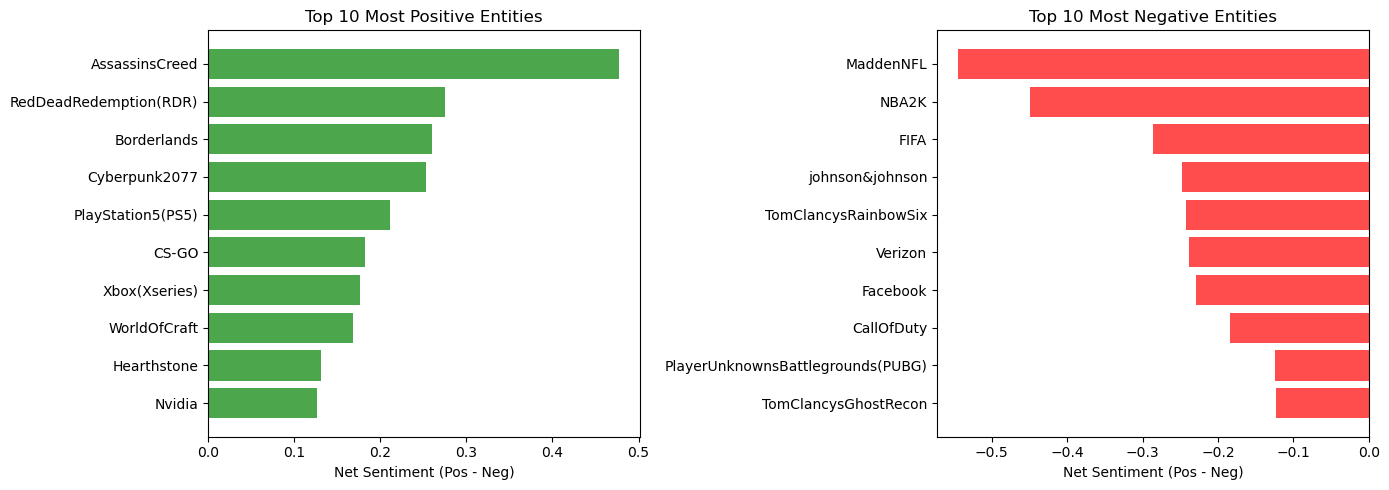

Created net sentiment comparison charts


In [7]:
# Create comparative bar charts for net sentiment and sentiment composition
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 most positive and most negative entities
top10_pos = ct.sort_values('net_sent', ascending=False).head(10)
top10_neg = ct.sort_values('net_sent').head(10)

# Net sentiment comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Most positive
axes[0].barh(top10_pos.index, top10_pos['net_sent'], color='green', alpha=0.7)
axes[0].set_xlabel('Net Sentiment (Pos - Neg)')
axes[0].set_title('Top 10 Most Positive Entities')
axes[0].invert_yaxis()

# Most negative
axes[1].barh(top10_neg.index, top10_neg['net_sent'], color='red', alpha=0.7)
axes[1].set_xlabel('Net Sentiment (Pos - Neg)')
axes[1].set_title('Top 10 Most Negative Entities')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print('Created net sentiment comparison charts')

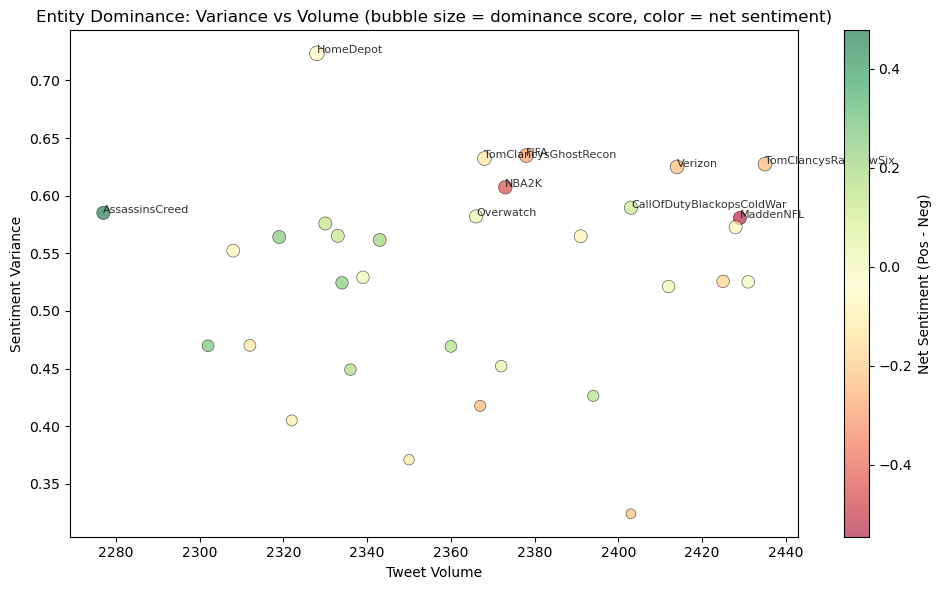

Created dominance bubble chart


In [8]:
# Visualize entity dominance: sentiment variance vs volume, and net sentiment comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 entities by dominance score
top15_dom = ct.sort_values('dominance_score', ascending=False).head(15)

# Plot 1: Sentiment variance vs volume (bubble chart)
plt.figure(figsize=(10,6))
plt.scatter(ct['volume'], ct['sent_var'], s=ct['dominance_score']*20, alpha=0.6, c=ct['net_sent'], cmap='RdYlGn', edgecolors='black', linewidth=0.5)
# Annotate top dominance entities
for idx in top15_dom.index[:10]:
    plt.annotate(idx, (ct.loc[idx, 'volume'], ct.loc[idx, 'sent_var']), fontsize=8, alpha=0.8)
plt.xlabel('Tweet Volume')
plt.ylabel('Sentiment Variance')
plt.title('Entity Dominance: Variance vs Volume (bubble size = dominance score, color = net sentiment)')
plt.colorbar(label='Net Sentiment (Pos - Neg)')
plt.tight_layout()
plt.show()

print('Created dominance bubble chart')